# How homeostatic term $\gamma$ affects the agreement between theory and simulation

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP

plt.rc('figure', figsize=(12.0, 8.0))

In [2]:
def wrap_half_period(x: torch.Tensor, period: int):
	return (x + period//2) % period - period//2

def circ_norm_unnormalised(x: torch.Tensor, mean: torch.Tensor, stdev: float, wrap: int):
	return torch.exp(-wrap_half_period(x - mean, wrap)**2 / 2/stdev**2)

def get_rotating_gaussian(time: int, neurons: int, bump_speed: int, stdev: float):
	t, x = torch.meshgrid(torch.arange(time),torch.arange(neurons))
	return circ_norm_unnormalised(x, (t*bump_speed) % neurons, stdev, neurons)

def convert_to_spikes(x: torch.Tensor, noise_ratio: float=0.0):
	return torch.rand_like(x) < (noise_ratio*torch.rand_like(x) + (1.0-noise_ratio)*(x / x.max()))

def sum_by_index(data: torch.Tensor, indices: torch.Tensor):
	return torch.zeros(indices.max().numpy()+1).index_add(0,indices.flatten(),data.flatten().float())

def roll_tensor_rows(tensor, roll_amounts):
	tensor_rolled = tensor[:, [*range(tensor.shape[1]),*range(tensor.shape[1]-1)]].clone()
	stride_0, stride_1 = tensor_rolled.stride()
	num_cols = tensor.shape[1]
	result = torch.as_strided(tensor_rolled, (*tensor.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[torch.arange(tensor.shape[0]), (num_cols-roll_amounts) % num_cols]

def get_time_periodic_profile(data: torch.Tensor, bump_speed: int):
	'''
	Return the average periodic spiking profile for the network (shifted so the centre angle is in the middle)

	:param data: Spiking output of the network [time*neurons]
	:param bump_speed: How many neurons the neural activity moves per timestep
	'''
	neurons = data.shape[1]
	shifts = -torch.arange(neurons) // bump_speed
	period = neurons // bump_speed
	return torch.roll(torch.mean(torch.vstack(torch.split(roll_tensor_rows(data.T.float(), shifts), period, dim=1)), dim=0), period//2)

def get_weight_periodic_profile(weights: torch.Tensor):
	'''
	Return the average periodic weight profile for the network (shifted so the centre angle is in the middle)

	:param weights: Weight matrix of the network [neurons*neurons]
	'''
	neurons = weights.shape[0]
	return torch.roll(torch.mean(roll_tensor_rows(weights, -torch.arange(neurons)), dim=0), neurons//2)

def get_weight_periodic_profile_stdev(weights: torch.Tensor):
	'''
	Return the standard deviation of the average periodic weight profile for the network (shifted so the centre angle is in the middle)

	:param weights: Weight matrix of the network [neurons*neurons]
	'''
	neurons = weights.shape[0]
	return torch.roll(torch.sqrt(torch.var(roll_tensor_rows(weights, -torch.arange(neurons)), dim=0)), neurons//2)

def plot_with_stdev(t, x, stdev, **kwargs):
	plt.plot(t, x, **kwargs)
	plt.fill_between(t, x-stdev, x+stdev, alpha=0.2)

Create the input for the network

In [3]:
time = 10000 # 10 seconds seems to be enough time for it to settle
num_neurons = 200
bump_speed = 1
period = num_neurons // bump_speed
input_noise_ratio = 0.
input_weight = 4 # mV / spike
dt = 1e-3 # time resolution is 1 ms

input_voltage = get_rotating_gaussian(time, num_neurons, bump_speed, num_neurons//10)
input_spikes = input_weight * convert_to_spikes(input_voltage, input_noise_ratio)

Create the network of LIF neurons with homeostatic+STDP plasticity.

In [4]:
def run_network(A_plus, A_minus, tau_stdp, gamma, input_spikes, input_weight):
	network = Network()

	# Create and add input, output layers.
	lif_layer = HomestaticLIFNodes(n=num_neurons, homeostatic_traces=True, traces=True, traces_additive=True, tc_trace=tau_stdp*1e3, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)

	network.add_layer(layer=lif_layer, name='LIF')

	initial_weights = 0.1 * (torch.rand((lif_layer.n,lif_layer.n)))
	recurrent_connection = Connection(
		source=lif_layer,
		target=lif_layer,
		update_rule = HomeostaticSTDP,
		nu=[-A_minus, A_plus],
		gamma = gamma,
		w=initial_weights,
	)
	network.add_connection(connection=recurrent_connection, source='LIF', target='LIF')

	# Create and add monitors for spikes and voltages
	monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r', 'x'), time=input_spikes.shape[0])
	network.add_monitor(monitor=monitor, name='LIF_monitor')

	# Simulate network on input data
	network.run(inputs={'LIF': input_weight*input_spikes}, time=input_spikes.shape[0])

	# Retrieve data from monitors for analysis
	spikes = monitor.get('s').squeeze()
	voltages = monitor.get('v').squeeze()
	stdp_traces = monitor.get('x').squeeze()
	rates = monitor.get('r').squeeze()

	return spikes, voltages, stdp_traces, rates, recurrent_connection.w

In [5]:
def plot_activity_profile(spikes):
	plt.plot(torch.arange(-period/2,period/2), get_time_periodic_profile(spikes, bump_speed))
	plt.title('Activity profile of network \n(relative to the centre neuron of Gaussian bump at each timestep)')
	plt.xlabel('relative time offset (ms)')
	plt.show()

def plot_firing_rate(rates):
	avg = rates.mean(dim=1)
	stdev = torch.sqrt(rates.var(dim=1))
	converged_firing_rate = rates[-time//2:].mean()
	plot_with_stdev(torch.arange(time), avg, stdev)
	plt.legend(['mean firing rate','$\\pm1$ standard deviation'])
	plt.title(f'Average neuron firing rate traces - converged rate = {converged_firing_rate:.3f} Hz')
	plt.xlabel('time (ms)')
	plt.ylabel('firing rate (Hz)')
	plt.show()
	return converged_firing_rate

def get_analytical_weights(gamma, converged_firing_rate):
	K_S = (A_plus + A_minus)*tau_stdp
	K_A = (A_plus - A_minus)*tau_stdp**2

	beta_S = K_S / (gamma * period * converged_firing_rate)
	beta_A = K_A / (gamma * period * converged_firing_rate)

	analytical_weights = np.zeros((num_neurons,num_neurons))
	for pre in range(num_neurons):
		for post in range(num_neurons):
			x_pre = input_voltage[pre,:period] / dt / 2
			x_post = input_voltage[post,:period] / dt / 2
			x_post_dot = np.diff(x_post) / dt
			x_pre = x_pre[:len(x_post_dot)]
			x_post = x_post[:len(x_post_dot)]
			analytical_weights[pre,post] = (beta_S*x_pre*dt*x_post*dt).sum()/dt + (beta_A*x_pre*dt*x_post_dot*dt).sum()/dt
	return analytical_weights

def plot_weights(weights, analytical_weights):
	fig, axs = plt.subplots(1,2, sharey=True)
	min_weight = min(analytical_weights.min().item(), weights.min().item())
	max_weight = max(analytical_weights.max().item(), weights.max().item())

	img1 = axs[0].imshow(weights, vmin=min_weight, vmax=max_weight, aspect='auto')
	img2 = axs[1].imshow(analytical_weights, vmin=min_weight, vmax=max_weight, aspect='auto')
	axs[0].set_title('Actual weights')
	axs[1].set_title('Analytical weights')
	axs[0].set_ylabel('Neuron index (from)')
	axs[0].set_xlabel('Neuron index (to)')
	axs[1].set_xlabel('Neuron index (to)')

	fig.subplots_adjust(right=0.85)
	cbar_ax = fig.add_axes([0.88, 0.1, 0.03, 0.8])
	fig.colorbar(img2, cax=cbar_ax)
	plt.show()

	plot_with_stdev(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(weights), get_weight_periodic_profile_stdev(weights), label='actual weights')
	plot_with_stdev(torch.arange(-num_neurons/2,num_neurons/2), get_weight_periodic_profile(torch.Tensor(analytical_weights)), get_weight_periodic_profile_stdev(torch.Tensor(analytical_weights)), label='predicted weights')
	plt.legend()
	plt.title('Predicted and actual neuron connection weight profiles')
	plt.xlabel(r'Neuron connection offset ($n_{\rm{to}} - n_{\rm{from}}$)')
	plt.ylabel('synaptic strength')
	plt.show()

Run the network for 5 different $\gamma$ values - see the difference

In [6]:
A_plus = 1e-2
A_minus = -1e-2
tau_stdp = 10e-3

def run_sim_and_plot(gamma):
	spikes, voltages, stdp_traces, rates, weights = run_network(A_plus, A_minus, tau_stdp, gamma, input_spikes, input_weight)

	plot_activity_profile(spikes)
	converged_firing_rate = plot_firing_rate(rates)
	analytical_weights = get_analytical_weights(gamma, converged_firing_rate)
	plot_weights(weights, analytical_weights)

###  $\gamma = 1 \times 10^{-5}$
Very low homeostatic term - output activity isn't a Gaussian but has constant background firing

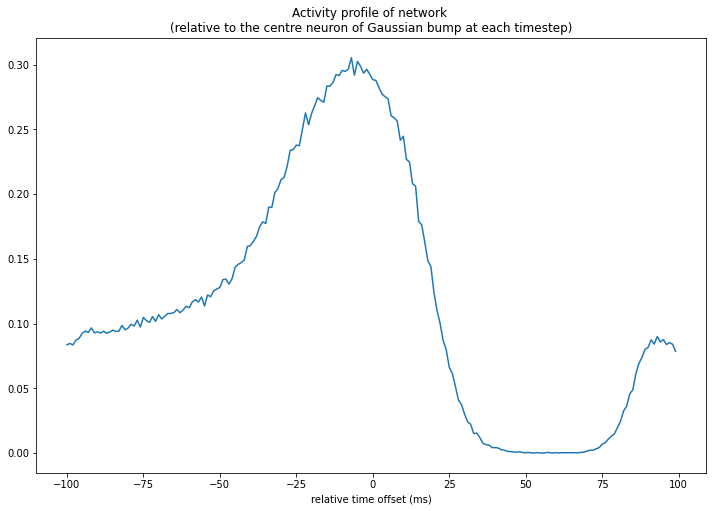

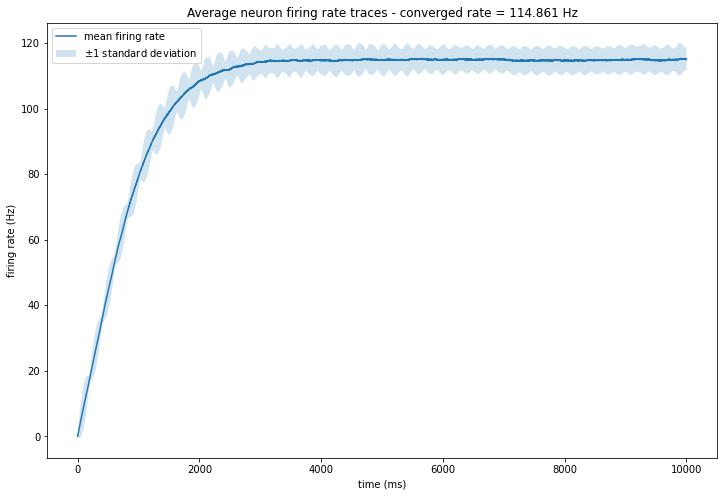

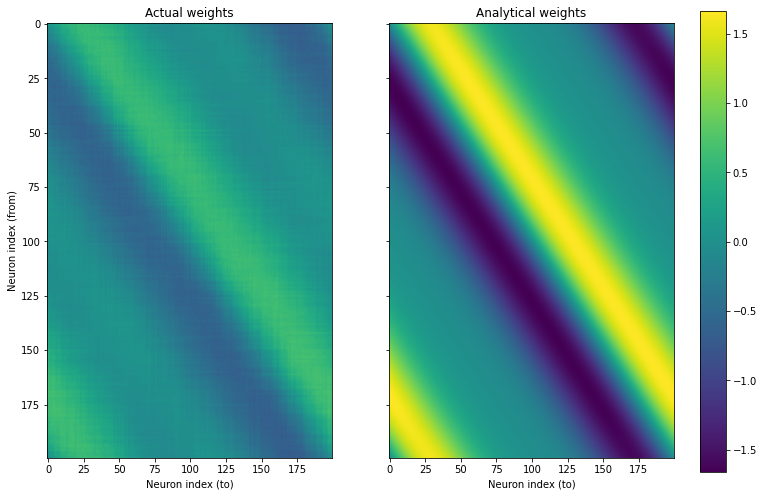

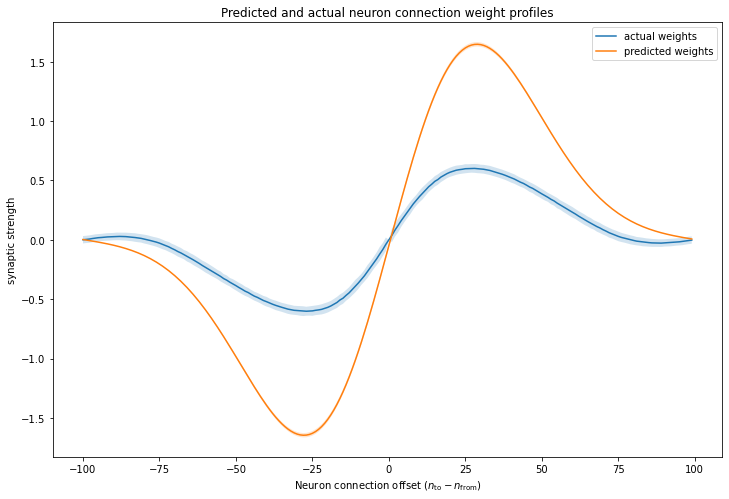

In [7]:
run_sim_and_plot(gamma=1e-5)

###  $\gamma = 5 \times 10^{-5}$
Low homeostatic term - activity is almost Gaussian but not quite

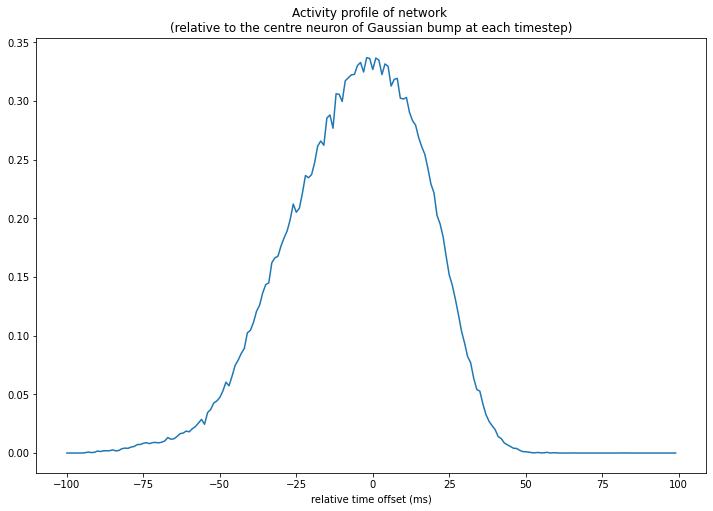

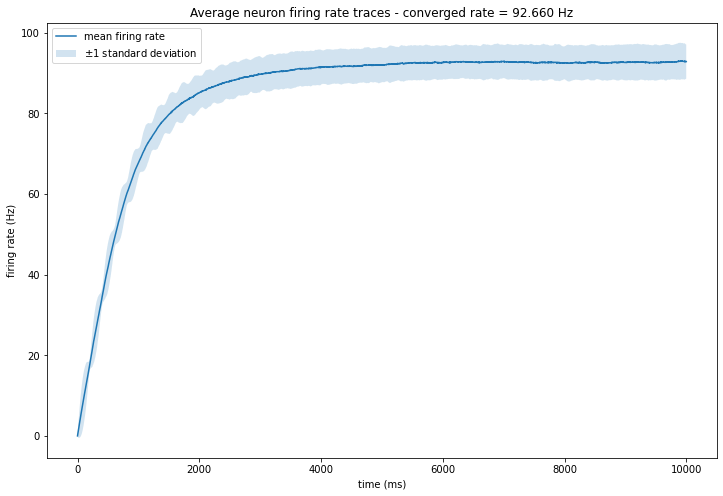

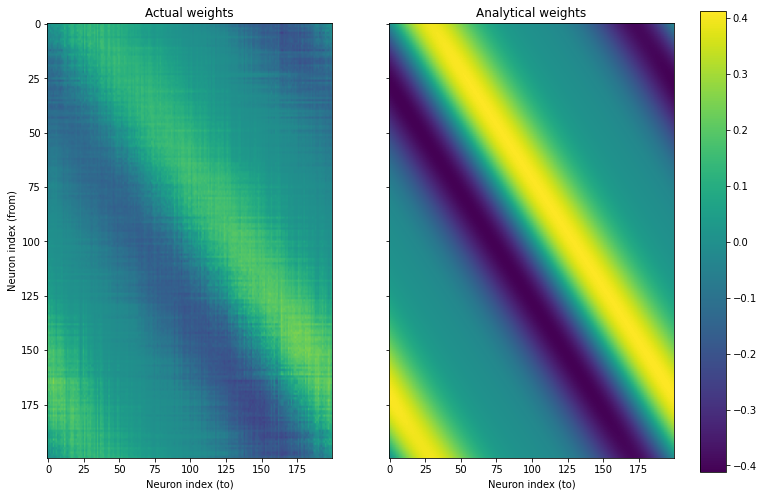

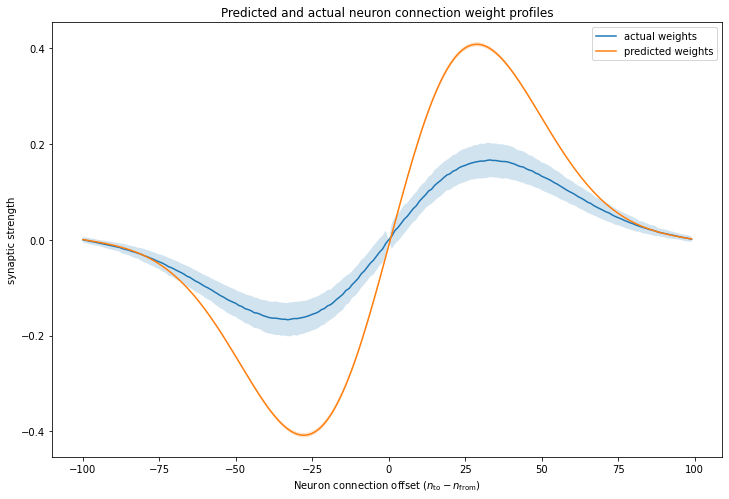

In [8]:
run_sim_and_plot(gamma=5e-5)

###  $\gamma = 1 \times 10^{-4}$
Medium homeostatic term
- activity is close to a nice Gaussian
- from here on the output firing rate stays at approximately 90 Hz
- weights for the neurons in the second half of the population is stronger than the first

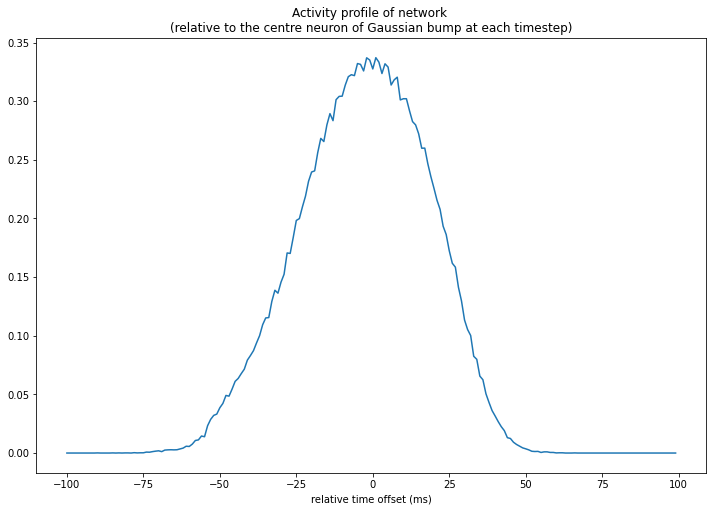

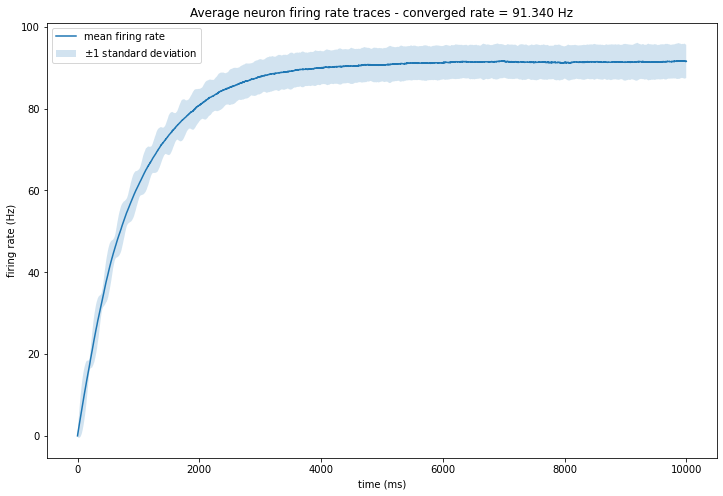

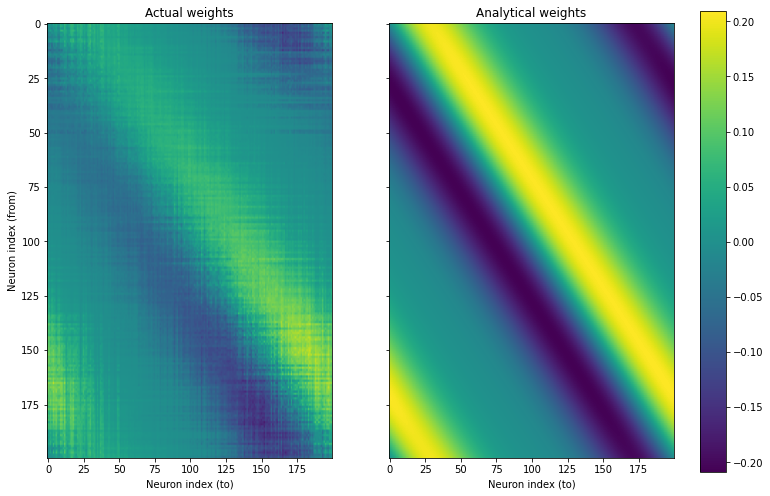

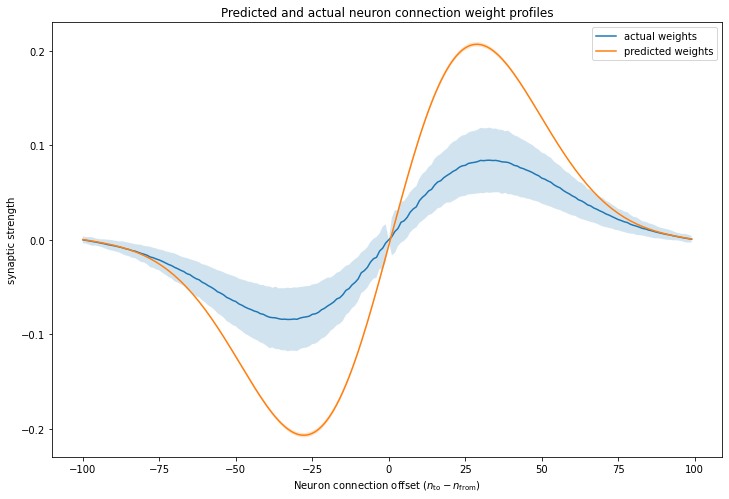

In [9]:
run_sim_and_plot(gamma=1e-4)

###  $\gamma = 5 \times 10^{-4}$
High homeostatic term
- activity profile is a nice Gaussian
- connection weights are very weak - seems like activity is being driven purely by the input
- second half of population weights much stronger than first half - why?
  - because of the strong homeostatic decay the weights decay almost to zero over the course of one period

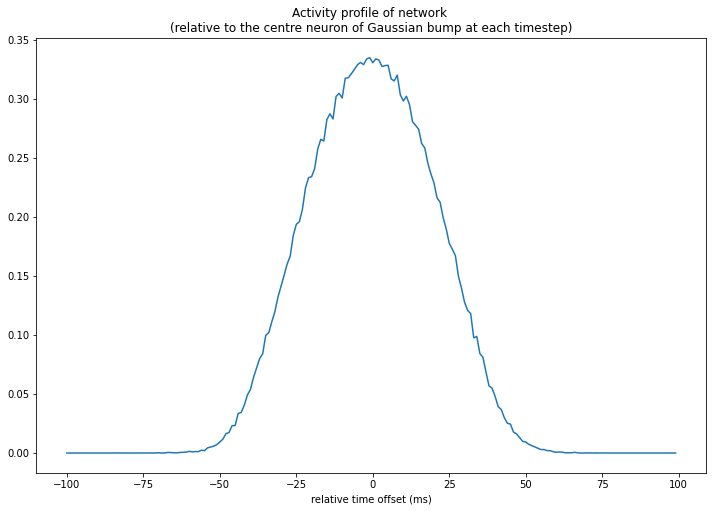

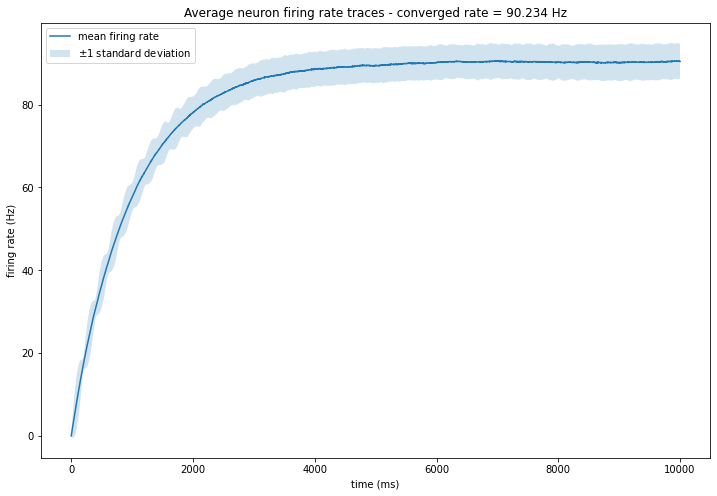

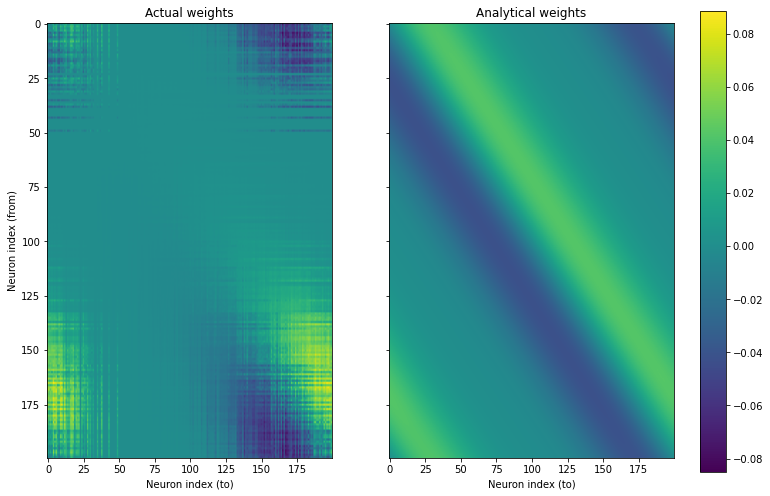

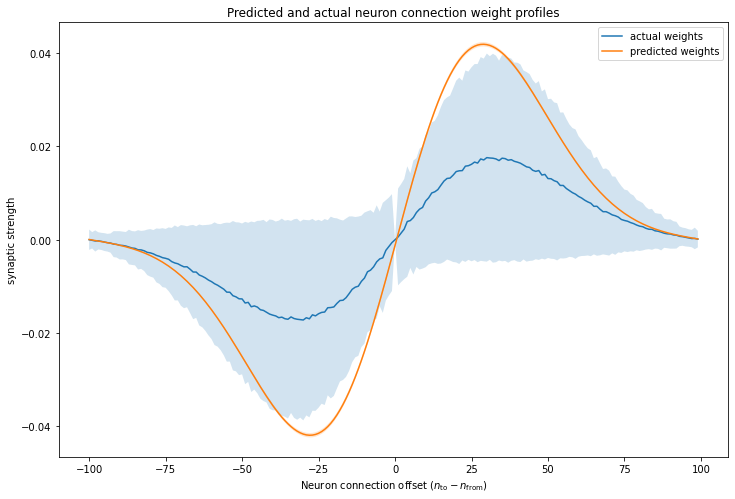

In [10]:
run_sim_and_plot(gamma=5e-4)

###  $\gamma = 1 \times 10^{-3}$
Very high homeostatic term
- half the weight matrix is "on" and half is "off" because of the strong decay

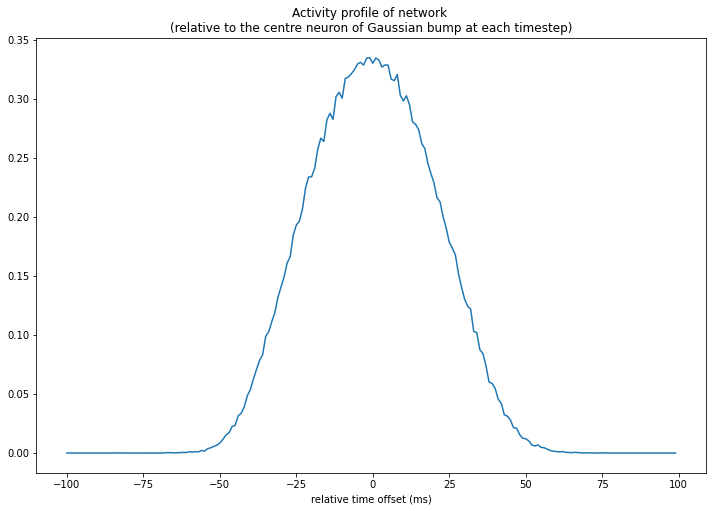

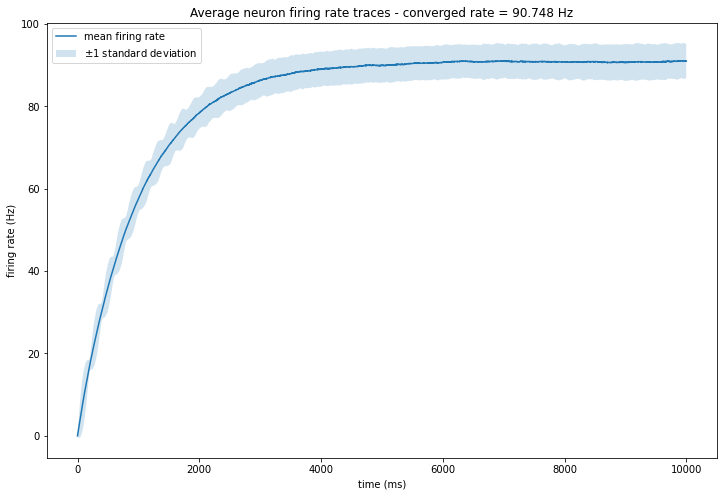

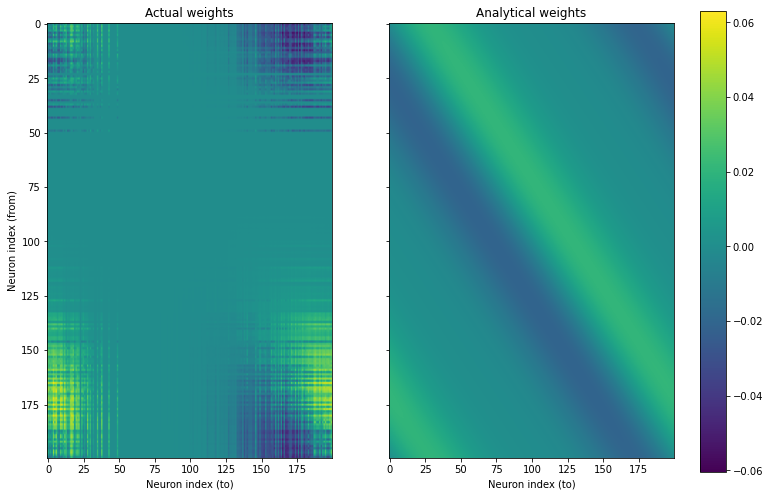

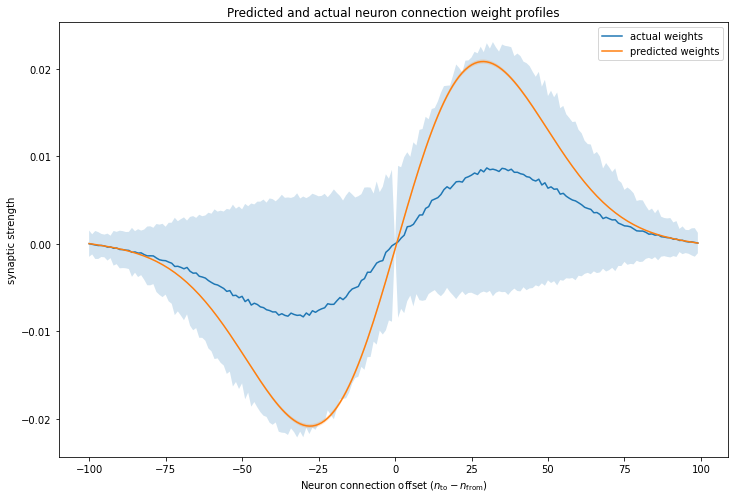

In [11]:
run_sim_and_plot(gamma=1e-3)